# AIoT Project

In [73]:
import os

# basic data engineering
import pandas as pd
import numpy as np
import scipy

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# db
import pymongo

# configs & other
import yaml
from tqdm.notebook import tqdm_notebook
from datetime import datetime
from time import time

from psynlig import pca_explained_variance_bar

# utils processing
from utils import sliding_window_pd
from utils import apply_filter
from utils import filter_instances
from utils import flatten_instances_df
from utils import df_rebase
from utils import rename_df_column_values

# utils visualization
from utils_visual import plot_instance_time_domain
from utils_visual import plot_instance_3d_acc
from utils_visual import plot_instance_3d_gyr
from utils_visual import plot_np_instance
from utils_visual import plot_heatmap
from utils_visual import plot_scatter_pca

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Start time of execution

In [74]:
time_start = time()

## Load configuration

In [75]:
config_path = os.path.join(os.getcwd(), "config.yml")

with open(config_path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [76]:
client = pymongo.MongoClient(config["client"])

In [77]:
db = client[config["db"]]
coll = db[config["col"]]

In [78]:
found_keys = coll.distinct("label")
print("Existing DB keys:", found_keys)


Existing DB keys: ['circle_left', 'circle_right', 'down', 'left', 'right', 'up', 'wrist_left', 'wrist_right']


## Process Data from MongoDB

In [79]:
documents = list() 

for document in coll.find({},{"_id": 0,"data": 1,"label": 1}):
    data_df = pd.DataFrame(document['data'])
    data_df['label'] = document['label']
    documents.append(data_df)

#DataFrames όλα σε ένα
final_df = pd.concat(documents, ignore_index=True)
print(final_df)
print(final_df.columns)


       acc_x  acc_y  acc_z    gyr_x   gyr_y   gyr_z        label
0     -0.091  0.119  0.968  -96.220  -0.732  51.768  circle_left
1     -0.061  0.117  0.971  -97.317  -0.732  51.280  circle_left
2     -0.061  0.105  0.961  -99.573  -1.463  45.488  circle_left
3     -0.054  0.097  0.958 -100.976  -1.646  40.305  circle_left
4     -0.067  0.108  0.963 -105.854 -16.707  46.890  circle_left
...      ...    ...    ...      ...     ...     ...          ...
20944  0.091  0.339  0.911   -0.488   7.500  -0.427  wrist_right
20945  0.088  0.349  0.894   -2.317   3.354   1.098  wrist_right
20946  0.040  0.340  0.860   -6.402  -1.768   5.488  wrist_right
20947  0.081  0.332  0.906   -7.683  -4.207   5.366  wrist_right
20948  0.106  0.341  0.941   -2.805  -4.817   0.427  wrist_right

[20949 rows x 7 columns]
Index(['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'label'], dtype='object')


#### Visualize 3D data

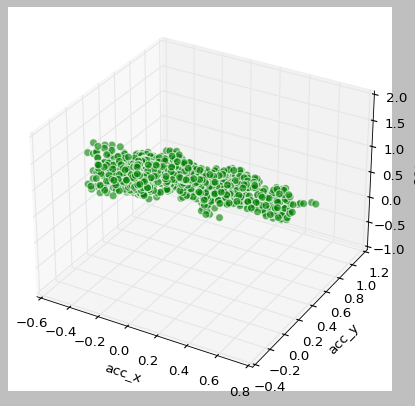

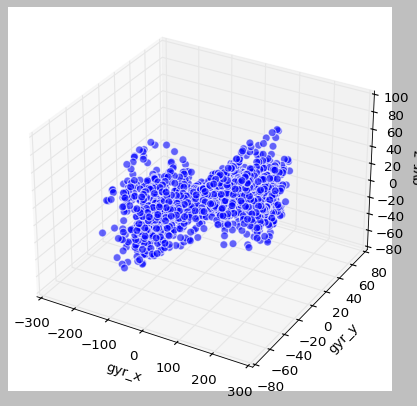

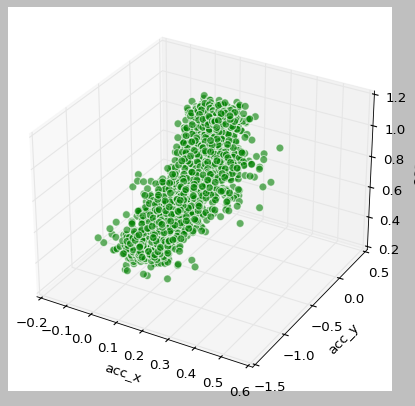

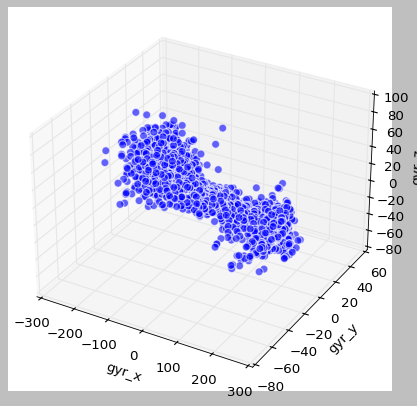

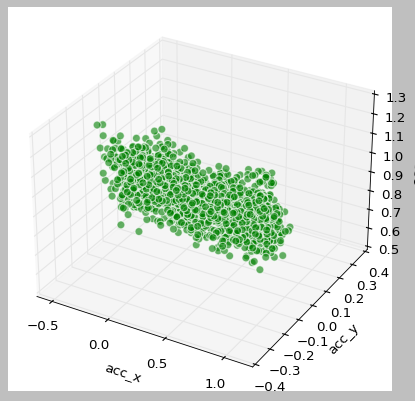

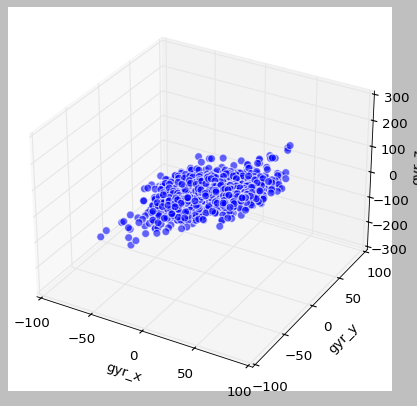

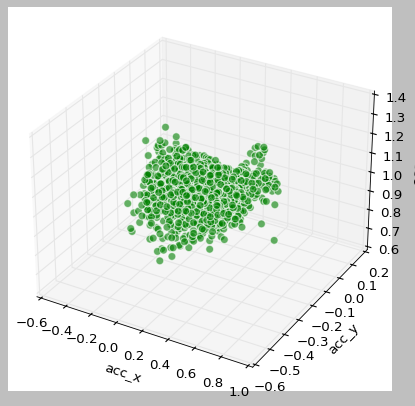

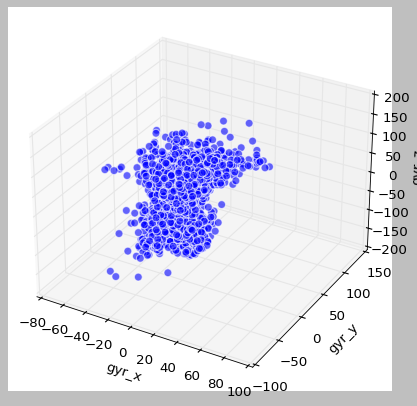

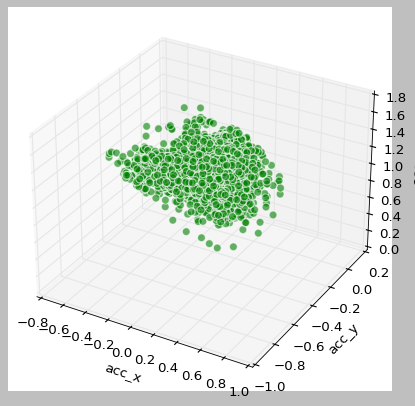

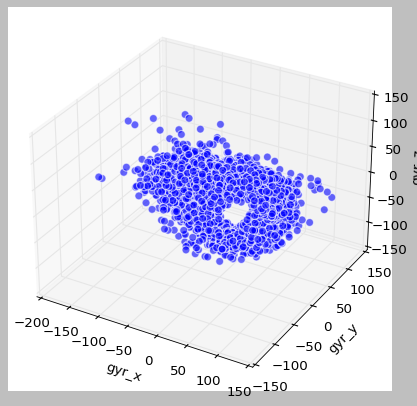

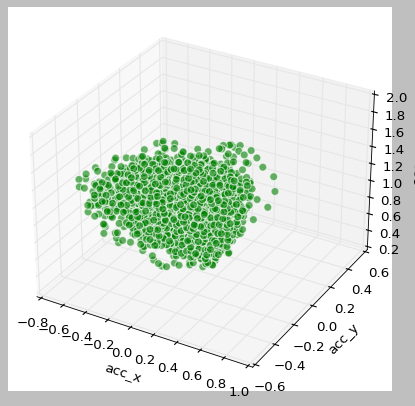

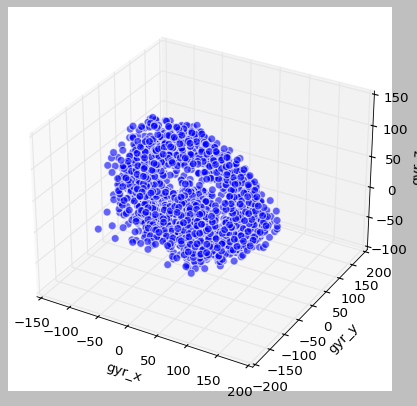

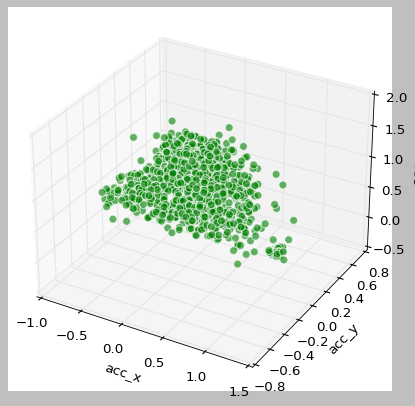

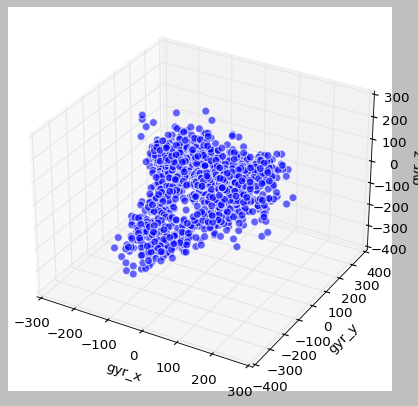

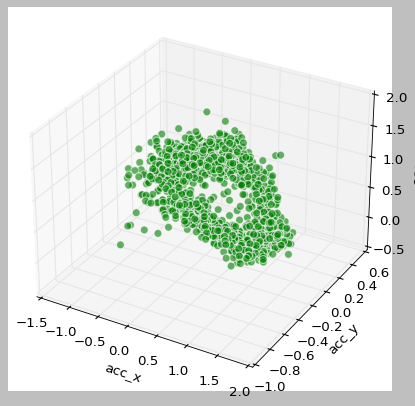

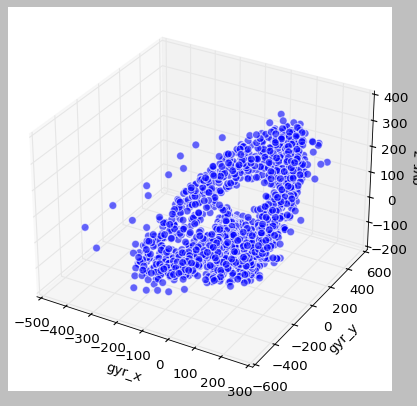

In [80]:
#up
plot_instance_3d_acc(final_df[final_df['label'] == 'up'])
plot_instance_3d_gyr(final_df[final_df['label'] == 'up'])
#down
plot_instance_3d_acc(final_df[final_df['label'] == 'down'])
plot_instance_3d_gyr(final_df[final_df['label'] == 'down'])
#left
plot_instance_3d_acc(final_df[final_df['label'] == 'left'])
plot_instance_3d_gyr(final_df[final_df['label'] == 'left'])
#right
plot_instance_3d_acc(final_df[final_df['label'] == 'right'])
plot_instance_3d_gyr(final_df[final_df['label'] == 'right'])
#circle_left
plot_instance_3d_acc(final_df[final_df['label'] == 'circle_left'])
plot_instance_3d_gyr(final_df[final_df['label'] == 'circle_left'])
#circle_right
plot_instance_3d_acc(final_df[final_df['label'] == 'circle_right'])
plot_instance_3d_gyr(final_df[final_df['label'] == 'circle_right'])
#wrist_left
plot_instance_3d_acc(final_df[final_df['label'] == 'wrist_left'])
plot_instance_3d_gyr(final_df[final_df['label'] == 'wrist_left'])
#wrist_right
plot_instance_3d_acc(final_df[final_df['label'] == 'wrist_right'])
plot_instance_3d_gyr(final_df[final_df['label'] == 'wrist_right'])



## Apply filter

In [81]:

# Εφαρμογή του φίλτρου σε κάθε στήλη ξεχωριστά
filtered_data = {}
sensor_columns = final_df.filter(regex='^(acc_|gyr_)').columns.tolist()
labels = final_df['label'].values

filter_order = config['filter']['order']
filter_wn = config['filter']['wn']
filter_type = config['filter']['type']


for column in sensor_columns:
    sensor_data = final_df[column].values  
    filtered_signal = apply_filter(sensor_data, filter_order, filter_wn, filter_type)
    filtered_data[column] = filtered_signal  # Αποθήκευση φιλτραρισμένων δεδομένων σε λεξικό
    

filtered_df = pd.DataFrame(filtered_data)
filtered_df['label'] = labels
print(filtered_df)


          acc_x     acc_y     acc_z       gyr_x      gyr_y      gyr_z  \
0     -0.054012  0.114045  0.937473 -100.493237 -15.902258  59.079829   
1     -0.052526  0.112450  0.942550 -103.795373 -20.830609  60.022938   
2     -0.054639  0.110771  0.952080 -107.477093 -25.551011  60.042062   
3     -0.061052  0.109060  0.966234 -111.346100 -29.739317  58.824457   
4     -0.072259  0.107370  0.984790 -115.163303 -33.086666  56.084118   
...         ...       ...       ...         ...        ...        ...   
20944  0.085507  0.333738  0.904002   -1.415279  -0.770832   6.119413   
20945  0.085528  0.333720  0.903956   -1.366437  -0.607714   6.097110   
20946  0.085533  0.333715  0.903942   -1.352128  -0.559886   6.090626   
20947  0.085533  0.333714  0.903939   -1.349309  -0.550453   6.089357   
20948  0.085533  0.333714  0.903939   -1.349033  -0.549529   6.089234   

             label  
0      circle_left  
1      circle_left  
2      circle_left  
3      circle_left  
4      circle_left

## Transform the list of DataFrames to NumPy array

Transform the list of DataFrames to NumPy array that contains the windows: (instances, x, y)

In [82]:
#sliding_window:
sl_win_ws = config['sliding_window']['ws']
sl_win_overlap = config['sliding_window']['overlap']
sl_win_w_type = config['sliding_window']['w_type']
sl_win_w_center = config['sliding_window']['w_center']
sl_win_print_stats = config['sliding_window']['print_stats']

windows_list = sliding_window_pd(
    filtered_df, 
    ws=sl_win_ws, 
    overlap=sl_win_overlap, 
    w_type=sl_win_w_type, 
    w_center=sl_win_w_center, 
    print_stats=sl_win_print_stats
)
print(windows_list)


Print Window: 15
Number of samples: 150
Print Window: 16
Number of samples: 150
Print Window: 17
Number of samples: 150
Print Window: 18
Number of samples: 150
Print Window: 19
Number of samples: 150
Print Window: 20
Number of samples: 150
Print Window: 21
Number of samples: 150
Print Window: 22
Number of samples: 150
Print Window: 23
Number of samples: 150
Print Window: 24
Number of samples: 150
Print Window: 25
Number of samples: 150
Print Window: 26
Number of samples: 150
Print Window: 27
Number of samples: 150
Print Window: 28
Number of samples: 150
Print Window: 29
Number of samples: 150
Print Window: 30
Number of samples: 150
Print Window: 31
Number of samples: 150
Print Window: 32
Number of samples: 150
Print Window: 33
Number of samples: 150
Print Window: 34
Number of samples: 150
Print Window: 35
Number of samples: 150
Print Window: 36
Number of samples: 150
Print Window: 37
Number of samples: 150
Print Window: 38
Number of samples: 150
Print Window: 39
Number of samples: 150


## Flatten the 2D window instances

Flatten the X NumPy array that contains the 2D window instances

In [83]:
labels = [window['label'].iloc[0] for window in windows_list]
windows_without_labels = [window.drop(columns='label') for window in windows_list]

#X = np.array([window.drop('label', axis=1).values for window in flattened_window])
df_flattened = flatten_instances_df(windows_without_labels)
df_flattened['label'] = labels
print(df_flattened)


             0         1         2           3           4           5  \
0    -0.054012  0.114045  0.937473 -100.493237  -15.902258   59.079829   
1    -0.088475  0.105750  1.007080 -118.654411  -35.328866   51.588061   
2    -0.228856  0.099249  1.120899 -121.234791  -26.597125    1.013653   
3    -0.354683  0.089787  1.050429  -83.029909    0.333646  -72.503420   
4    -0.315244  0.056603  0.709712  -12.939482   14.461194 -113.361767   
...        ...       ...       ...         ...         ...         ...   
4155  0.120353  0.168922  0.937557   17.105855  -36.801307    4.891691   
4156  0.377785  0.183850  0.748484  -29.229203 -240.000684  -26.210661   
4157  0.915942  0.116622  0.373489 -118.415553 -362.742960  -34.870608   
4158  1.263755 -0.049877  0.053566 -137.548532 -182.746907   54.544905   
4159  0.996329 -0.229922  0.092984  -29.288499  168.216425  202.937195   

             6         7         8           9  ...        891         892  \
0    -0.052526  0.112450  0.94255

In [84]:
from utils import encode_labels
X = df_flattened.drop('label', axis=1)
y_label = df_flattened['label']

y = encode_labels(y_label)


## Train/Test split

In [85]:
from sklearn.model_selection import train_test_split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

In [87]:
print(X.shape,X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4160, 900) (3328, 900) (832, 900) (3328,) (832,)


## Scaling

In [88]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [89]:
# Αρχικοποίηση του scaler
scaler = MinMaxScaler()
# Fit και transform στα χαρακτηριστικά (X)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Dimensionality Reduction with PCA using the 1D (flattened) data

In [90]:
# add transformers
from sklearn.decomposition import PCA

### PCA with 2 Components

In [91]:
# Define PCA with 2 components

n = config['PCA']['n_comp_2']
pca2d = PCA(n_components = n)
X_pca2d = pca2d.fit_transform(X_train)
print(X_pca2d)


[[-0.90164925  0.02989117]
 [-0.21423343  0.48944037]
 [-0.296712    1.2569195 ]
 ...
 [-0.65383825  3.11162423]
 [ 0.53012431  1.04322809]
 [-0.1004495   1.46517027]]


Σχήμα μετά το PCA με 2 συνιστώσες: (3328, 2)


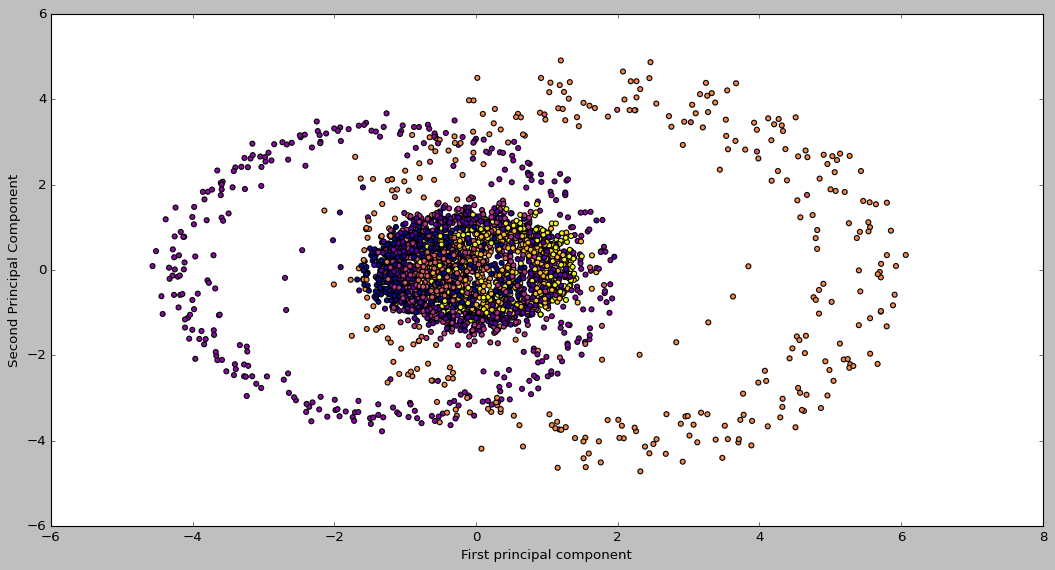

In [92]:
pca_df = pd.DataFrame(data=X_pca2d, columns=['PC1', 'PC2'])
pca_df['label'] = y_train  # Add labels to the DataFrame

# Plot 2D PCA results
print(f"Σχήμα μετά το PCA με 2 συνιστώσες: {X_pca2d.shape}")
plot_scatter_pca(pca_df, c_name='label')

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Principal component', ylabel='Explained variance (fraction) per component'>)

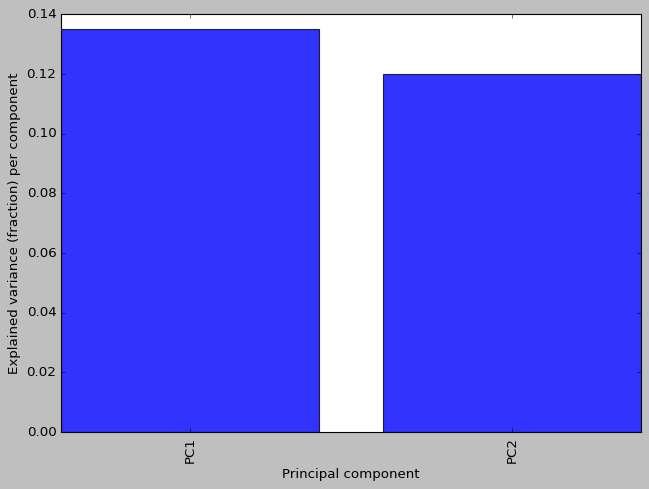

In [93]:
pca_explained_variance_bar(pca2d, alpha=0.8)

### PCA with 3 Components

In [94]:
# Define PCA with 3 components
n = config['PCA']['n_comp_3']
pca3d = PCA(n_components=n)
X_pca3d= pca3d.fit_transform(X_train)
print(X_pca3d)


[[-0.90166266  0.02989888  1.09398197]
 [-0.21423578  0.48944135 -0.56752837]
 [-0.29671518  1.2569199  -0.17567463]
 ...
 [-0.65383431  3.11162472  3.91391758]
 [ 0.53012663  1.04322749 -0.22428469]
 [-0.10044205  1.46516518  0.16937858]]


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Principal component', ylabel='Explained variance (fraction) per component'>)

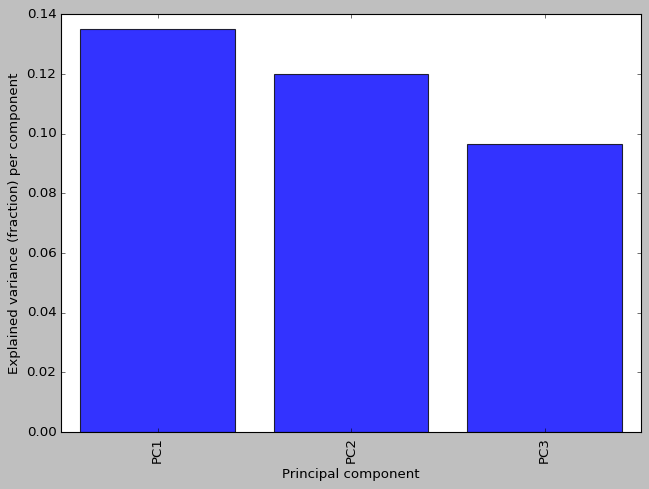

In [95]:

pca_explained_variance_bar(pca3d, alpha=0.8)


Σχήμα μετά το PCA με 3 συνιστώσες: (3328, 3)


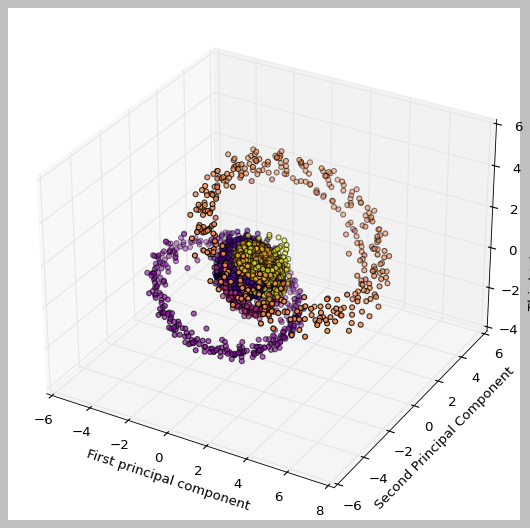

In [96]:
# Create DataFrame for 3D PCA results
pca3d_df = pd.DataFrame(data=X_pca3d, columns=['PC1', 'PC2', 'PC3'])
pca3d_df['label'] = y_train

# Plot 3D PCA results
print(f"Σχήμα μετά το PCA με 3 συνιστώσες: {X_pca3d.shape}")
plot_scatter_pca(pca3d_df, c_name='label')

### PCA with X% of the variance of the dataset, for training the statistical AI Models

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Principal component', ylabel='Explained variance (fraction) per component'>)

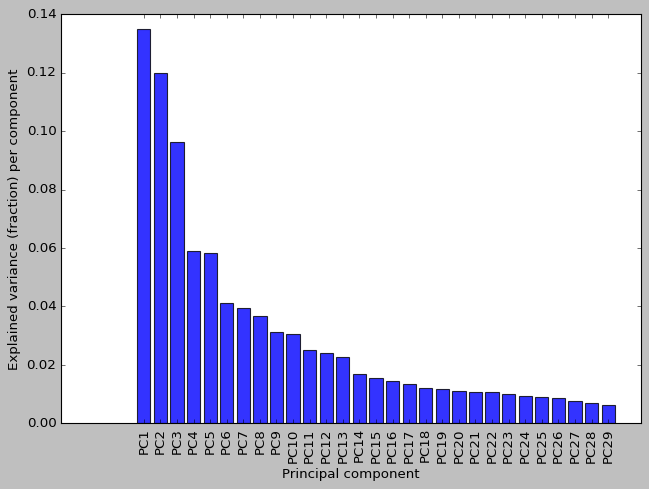

In [105]:
variance_ratio = 0.89  # Example variance ratio
pca_var = PCA(n_components=variance_ratio)
X_pca_train = pca_var.fit_transform(X_train)
X_pca_test = pca_var.transform(X_test)

pca_explained_variance_bar(pca_var, alpha=0.8)

## Classifier - Statistical Learning

### Apply simple classifier

In [106]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [107]:
# Initialize the classifiers
svc_params = config['classifier']['SVC']
svm_clasf = SVC(kernel=svc_params['kernel'], gamma=svc_params['gamma'], C= svc_params['C'])

In [108]:
svm_clasf.fit(X_pca_train, y_train)

SVC(C=10, gamma=0.5)

In [109]:
y_pred_svm = svm_clasf.predict(X_pca_test)
print(y_pred_svm)

[6 7 0 4 3 1 7 6 3 4 3 0 3 1 7 2 6 1 4 5 6 3 1 5 2 0 1 7 0 5 1 1 3 7 0 1 5
 7 3 0 2 1 0 2 5 2 0 3 0 1 1 3 5 4 2 2 2 4 5 0 2 4 2 4 1 6 7 2 4 5 4 7 0 1
 0 0 1 4 5 4 1 1 4 0 6 6 4 2 6 6 7 4 0 0 0 0 7 1 1 1 3 2 6 5 1 4 0 7 4 0 3
 6 0 3 6 2 0 0 0 1 1 3 1 4 0 0 7 1 4 1 2 0 6 7 6 5 0 7 4 1 6 0 3 7 3 3 4 2
 0 6 6 0 7 0 1 3 1 5 2 1 1 6 7 0 3 1 6 2 6 3 6 7 5 7 4 4 4 2 4 0 0 3 3 7 3
 5 5 1 1 7 5 2 0 6 4 1 4 0 2 2 1 7 0 1 1 0 1 6 5 5 5 7 2 5 2 3 7 5 3 3 7 5
 4 6 0 2 3 6 5 1 3 6 7 3 3 0 0 2 2 1 6 2 2 1 3 2 6 1 6 0 0 1 5 7 6 0 3 0 6
 7 7 4 7 7 3 2 7 7 5 4 0 0 6 0 5 1 6 2 3 1 6 6 1 6 6 6 2 7 0 1 7 0 5 2 6 4
 0 0 4 1 0 0 3 6 2 2 4 5 2 4 5 1 6 2 1 5 7 0 4 3 4 0 4 5 1 1 2 3 6 3 6 1 1
 6 1 3 4 1 3 4 0 6 0 1 0 7 0 4 7 6 3 1 0 4 2 0 0 3 4 5 6 3 1 7 6 7 6 0 6 1
 2 6 2 0 1 5 0 5 1 1 1 0 2 0 2 1 6 7 3 1 0 0 3 5 1 1 6 0 1 7 1 1 4 2 3 2 7
 2 1 1 2 7 3 5 2 7 0 5 7 2 7 0 4 4 0 3 0 1 7 7 1 3 6 4 5 0 4 1 1 0 1 4 2 6
 0 5 0 1 0 6 2 2 0 4 1 3 5 0 7 0 0 7 0 7 1 6 4 3 5 1 0 6 7 1 4 7 6 4 0 0 0
 4 4 4 5 1 5 0 5 6 4 1 5 

### Evaluate simple classifier

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [111]:
from sklearn.metrics import classification_report

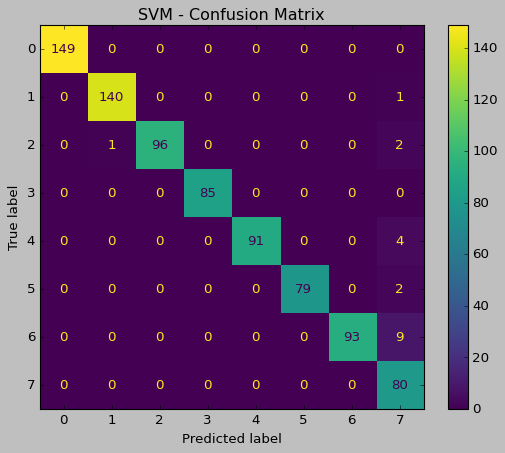

SVM - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       149
           1       0.99      0.99      0.99       141
           2       1.00      0.97      0.98        99
           3       1.00      1.00      1.00        85
           4       1.00      0.96      0.98        95
           5       1.00      0.98      0.99        81
           6       1.00      0.91      0.95       102
           7       0.82      1.00      0.90        80

    accuracy                           0.98       832
   macro avg       0.98      0.98      0.97       832
weighted avg       0.98      0.98      0.98       832



In [112]:
# Random Forest classifier evaluation
confusion_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(confusion_svm).plot()
plt.title("SVM - Confusion Matrix")
plt.show()

print("SVM - Classification Report")
print(classification_report(y_test, y_pred_svm))

### Apply optimization with Grid Search and Cross-validation

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

### Evaluate optimized classifier